# Урок: Детектирование объектов

## Задание

* Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?
* Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.


## G-RCNN

https://www.isical.ac.in/~sankar/paper/Anima-2021.pdf

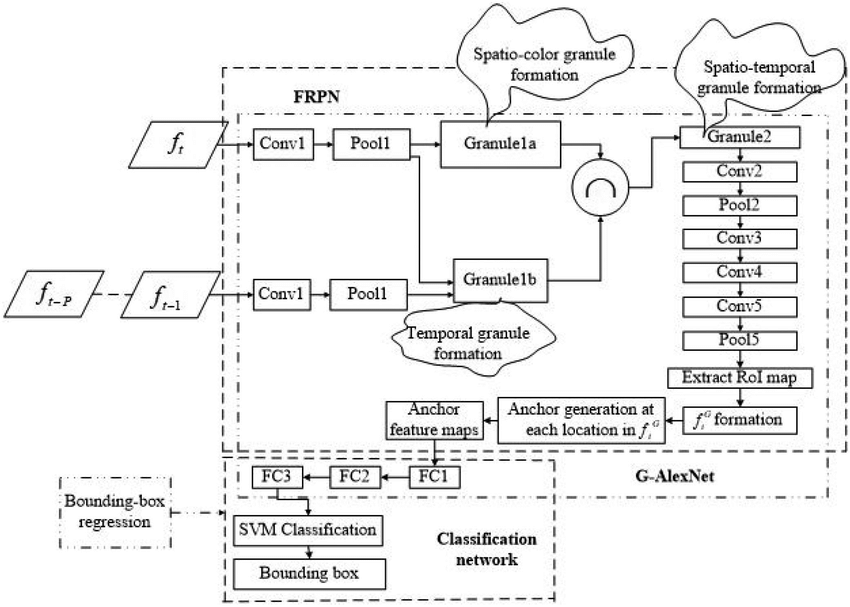

Гранулированная RCNN (G-RCNN) и мультиклассовая глубокая сортировка (MCD-SORT) для обнаружения и отслеживания объектов из видео.

Обнаружение объекта состоит из двух этапов: локализация объекта (область интереса RoI) и классификация.

G-RCNN - это улучшенная версия Fast RCNN и Faster RCNN для извлечения RoI за счет включения концепции грануляции в глубокую сверточную нейронную сеть.

Грануляция с пространственно-временной информацией позволяет более точно извлекать RoI в неконтролируемом режиме.

По сравнению с Fast и Faster RCNN, G-RCNN использует:

* гранулы (кластеры), сформированные на pooling слоях, вместо всех значений функций при определении RoI
* только положительные RoI во время обучения, а не все фичи
* видео в качестве входных данных, а не статические изображения

Все это приводит к повышению скорости и точности обнаружения в реальном времени.

MCD-SORT - это усовершенствованная форма Deep SORT. В MCD-SORT поиск ассоциации объектов с траекториями ограничен только в пределах тех же категорий. Это увеличивает производительность при отслеживании нескольких классов.

## Импорт библиотек

In [15]:
import os, fnmatch

from google.colab import drive

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image
import matplotlib.pyplot as plt

# For drawing onto the image
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time
import time
%matplotlib inline

In [2]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img


def run_detector(detector, path, max_boxes=3, min_score=0.01, title=''):
  img = load_img(path)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
    img.numpy(),
    result["detection_boxes"],
    result["detection_class_entities"],
    result["detection_scores"],
    max_boxes=max_boxes,
    min_score=min_score,
  )
  display_image(image_with_boxes, title)
  return result


def display_image(image, title):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)
  plt.title(title)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [4]:
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/Colab Notebooks/data/ssdMobile_v2/'

Mounted at /content/drive


In [5]:
pattern = '*.jpg'

images = []
for file in os.listdir(PATH):
  if fnmatch.fnmatch(file, pattern):
    images.append(os.path.join(PATH, file))

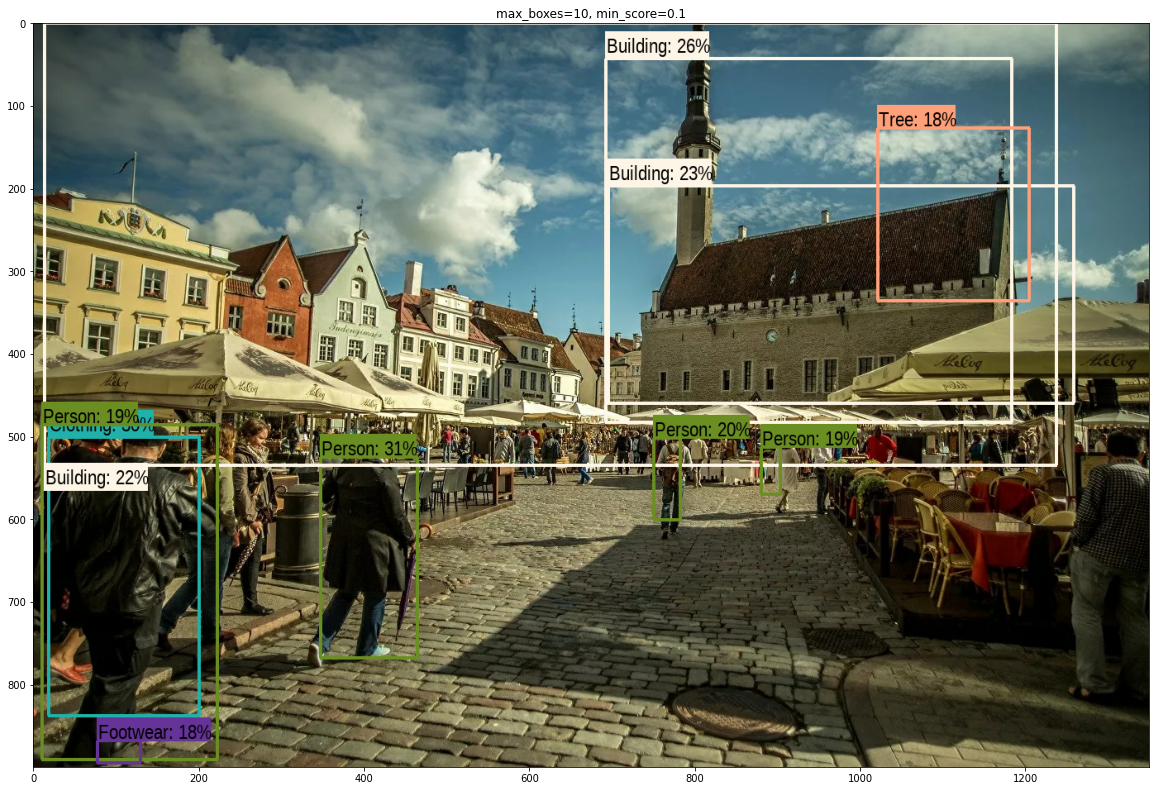

In [11]:
result_1 = run_detector(detector, images[0], 10, 0.1, title='max_boxes=10, min_score=0.1')

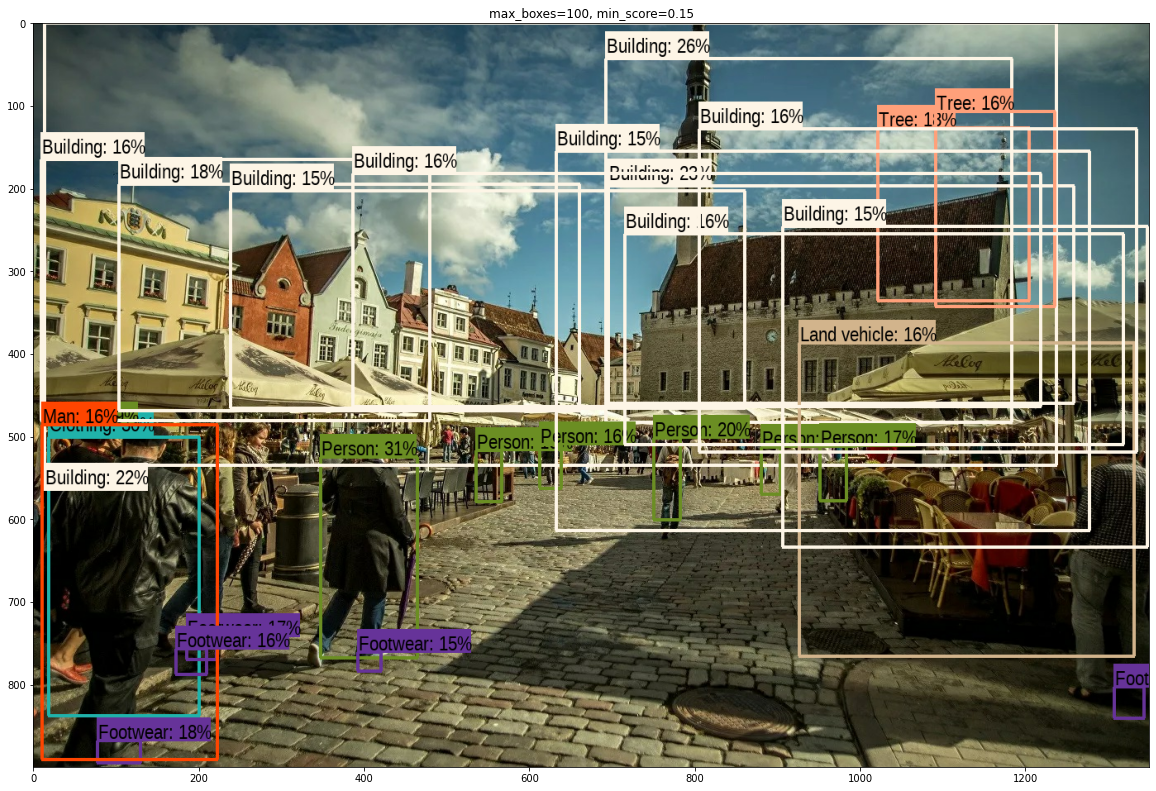

In [13]:
result_2 = run_detector(detector, images[0], 100, 0.15, title='max_boxes=100, min_score=0.15')

In [25]:
df = pd.DataFrame({
  'detection_class_entities': result_2['detection_class_entities'],
  'detection_class_labels': result_2['detection_class_labels'],
  'detection_scores': result_2['detection_scores'],
})

df.head(10)

detection_class_entities  detection_class_labels  detection_scores
0                b'Person'                      69          0.319577
1              b'Clothing'                     433          0.306631
2              b'Building'                     462          0.260433
3              b'Building'                     462          0.232804
4              b'Building'                     462          0.226304
5                b'Person'                      69          0.208856
6                b'Person'                      69          0.195690
7                b'Person'                      69          0.193537
8              b'Footwear'                     434          0.184109
9                  b'Tree'                     391          0.182844